<b>Imports</b>

<ul>
<li><b>keras.models</b> contains the calls to instantiate Neural Networks</li>
<li><b>keras.layers</b> contains the layers to be contained in Neural Networks</li>
<li><b>keras.optimizers</b> contains optimisation methods (mostly gradient descent)</li>
<li><b>util.py</b> contains auxiliary routines for data processing</li>
</ul>

In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM, Embedding, TimeDistributedDense
from keras.optimizers import Adam, SGD
from keras.layers.wrappers import TimeDistributed
import util

Using Theano backend.


<b>Other imports</b>

<ul>
<li><b>matplotlib.pyplot</b> contains calls for plotting in Python</li>
<li><b>numpy, scipy.io</b> required to manipulate dataset</li>
</ul>

In [2]:
import matplotlib
import matplotlib.pyplot as plt

###draw plots below notebook cells
%matplotlib inline   

###set the size of plot figures
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)  

import numpy as np
import scipy.io 

In this tutorial, we will perform one-step ahead prediction over the <b>Mackey Glass chaotic time series</b>.
The file <b>mg.mat</b> contains training and testing samples in the vectors <b>t_tr</b>, <b>t_te</b> respectively. 

The function <b>prepare_data</b> partitions the zero-mean, unit-variance vectors <b>t_tr, t_te</b> into overlapping frames with a stride of 1 sample. Each frame is a 99-sample subsection of the Mackey Glass dataset. <b>prepare_data</b> returns two objects:

<ul>
<li>X_train. Contains a list of 701 sequences, each with 99 unidimensional (scalar) samples. </li>
<li>y_train. Is the 1-step shifted version of X_train </li>
</ul>

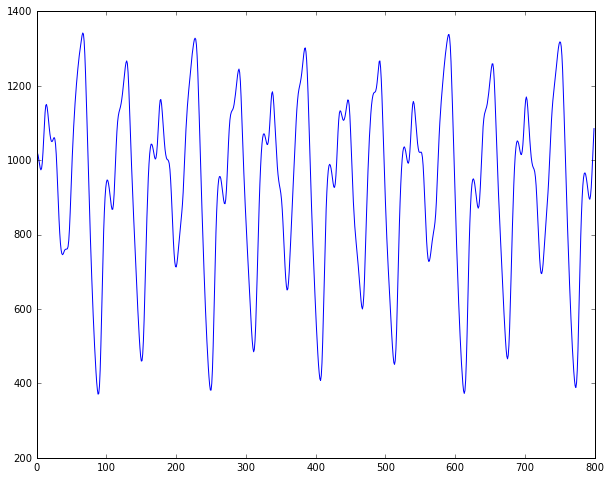

In [3]:
matdict = scipy.io.loadmat( 'mg.mat' )
t_tr = matdict['t_tr'].T

X_train, y_train = util.prepare_data( t_tr )
plt.plot( t_tr[0] )

We will now initialise some useful variables:
<ul>
<li><b>sample_length</b>: is the length of each observation. In this case, they are unidimensional observations.</li>
<li><b>timesteps</b>: number of observations per sequence. There are 99 observations in each input sequence. </li>
<li><b>h</b>: is a vector containing the number of per layer, starting with the input layer</li>
<li><b>n_lstm</b>: is the number of stacked LSTM layers in the model</li>
</ul>

In [4]:
sample_length = 1
timesteps = 99
h = [sample_length, 35, 20, 10, 8]
n_lstm = len( h ) - 1

The next step of the pipeline is to create an empty Neural Network:

In [5]:
model = Sequential()

And then we can stack layers on it. For this exercise, we will add 4 LSTM layers to our model.

The Keras LSTM layer receives the following parameters:
<ul>
<li><b>input_shape</b>: input needs to have the shape (timesteps, sample_length). Sample_length is simply the number of neurons at the previous layer.</li>
<li><b>output_dim</b>: the target dimension. This is the number of neurons in the current layer.</li>
<li><b>activation</b>: this is the activation function of the feedforward edges. For LSTMs, it is tanh by definition.</li>
<li><b>inner_activation</b>: the activation function of the recurrent edges. For LSTMs, this is the sigmoid by definition.</li>
<li><b>return_sequences</b>: whether to the whole sequence (h_1, h_2, ..., h_T) or just the last element h_T .</li>
</ul>

In [6]:
for i in range( n_lstm - 1 ):
    model.add( LSTM( input_shape=(timesteps,h[i]), 
                    output_dim=h[i+1], 
                    activation='tanh', 
                    inner_activation='sigmoid', 
                    return_sequences=True) )

To perform forecasting, we will add a last dense layer at each timestep. The TimeDistributed wrapper receives a Layer as input, and applies it to every timestep of the previous layer's result. 

In this case, we are using a simple Dense layer, whose only argument is its output dimension - which is equal to the sample length, since we want scalar predictions for the Mackey Glass time series.

The resulting architecture can be visualised below.

In [7]:
model.add( TimeDistributed( Dense(sample_length) ) )

<b>Our architecture:</b> the blue layer is the input layer, which is simply the input Mackey Glass Time series. The green boxes are the unfolded LSTM layers for each timestep. Finally, the orange box is the result of applying the Time Distributed Dense layer.
<img src="keras_fig.png"> 

So far, all the Keras calls have been translated into Theano/TensorFlow code in the background. This code needs to be compiled so that it can be used in real data. Additionally, this will also make performance optimisations (such as simplification of expressions).

The call to the compiler must also contain information about the loss function and the optimiser to use. If we want to use default parameters, we can just send these parameters as strings. Otherwise, we can send points to custom loss functions or Optimizer class objects (more of which are contained in <b>keras.optimizers</b>.

For our problem, we will try to minimise the mean squared error of our predictions with respect to the ground truth, and we will do so by using a variant of minibatch stochastic gradient descent called <b>Adam</b>.

In [8]:
model.compile(loss='mse',
              optimizer='adam')

Once we have compiled out model, we can call its fit method over our dataset in numpy arrays. For our training phase, we will scan the dataset 10 times (i.e. <b>10 epochs</b>). Furthermore, we will perform gradient descent updates every time we have scanned 50 samples (hence the minibatch size is <b>50 samples</b>). After every epoch, we will validate the new parameters on 20% of the dataset (validation split = 20%). 

In [9]:
hist = model.fit(X_train, y_train,
          nb_epoch=10,
          validation_split=0.2,
          batch_size=50)

Train on 560 samples, validate on 141 samples
Epoch 1/10
560/560 [==============================] - 2s - loss: 0.4200 - val_loss: 0.3247
Epoch 2/10
560/560 [==============================] - 1s - loss: 0.2575 - val_loss: 0.2236
Epoch 3/10
560/560 [==============================] - 1s - loss: 0.1817 - val_loss: 0.1595
Epoch 4/10
560/560 [==============================] - 1s - loss: 0.1282 - val_loss: 0.1189
Epoch 5/10
560/560 [==============================] - 1s - loss: 0.1003 - val_loss: 0.1015
Epoch 6/10
560/560 [==============================] - 1s - loss: 0.0883 - val_loss: 0.0941
Epoch 7/10
560/560 [==============================] - 1s - loss: 0.0821 - val_loss: 0.0887
Epoch 8/10
560/560 [==============================] - 1s - loss: 0.0775 - val_loss: 0.0846
Epoch 9/10
560/560 [==============================] - 1s - loss: 0.0738 - val_loss: 0.0805
Epoch 10/10
560/560 [==============================] - 1s - loss: 0.0702 - val_loss: 0.0766


Once training is complete, the model can be used to make predictions or to evaluate test data. The file <b>util.py</b> contains a function to make one-step ahead forecast, i.e. we forecast a single timestep from a seed, and use a new seed that contains the forecast. 

In the figure below, we have used the fifth-to-last training sample (with 99 observations) and forecast the next 800 timesteps from it. The figure shows the results we obtained.

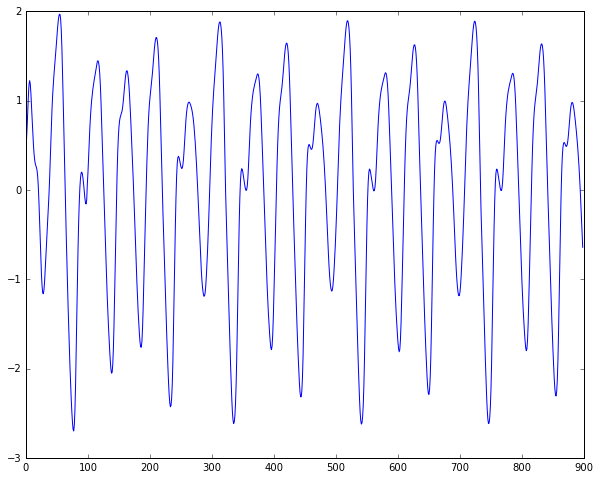

In [11]:
long_y_hat = 1.2*util.long_prediction( model, X_train[-5], 800, timesteps )
plt.plot( long_y_hat )

plt.show()